In [472]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import warnings
import matplotlib.ticker as ticker

from pandas.api.types import infer_dtype
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from xgboost import plot_tree
from xgboost import XGBRegressor
import warnings

sns.set_theme(style="darkgrid", palette=None) 
warnings.filterwarnings('ignore')

***
### Train.csv
***

In [473]:
train = pd.read_csv('train.csv')
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.00,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.00,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.00,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.00,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.00,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### Check Target Distribution

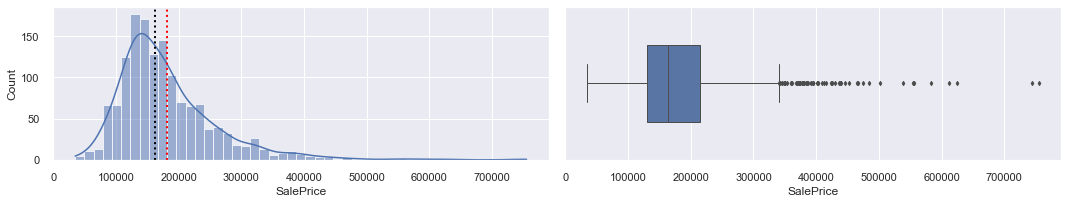

In [474]:
fig, ax = plt.subplots(1, 2, figsize= (15,3))

sns.histplot(ax=ax[0], data=train, x='SalePrice', kde= True)
sns.boxplot (ax= ax[1], data=train, x='SalePrice', linewidth= 1, fliersize=3, width=0.5)
ax[0].axvline(x=train['SalePrice'].mean(), ymax= 1, color= 'red',linestyle='dotted', linewidth=2)
ax[0].axvline(x=train['SalePrice'].median(), ymax= 1, color= 'black',linestyle='dotted', linewidth=2)


In [475]:
df = train
log_saleprice= np.log(df['SalePrice'])
df['log_saleprice']= log_saleprice

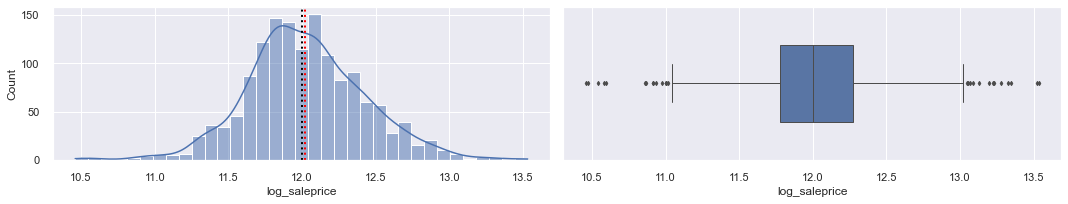

In [476]:
fig, ax = plt.subplots(1, 2, figsize= (15,3))

sns.histplot(ax=ax[0], data=df, x='log_saleprice', kde= True)
sns.boxplot (ax= ax[1], data=df, x='log_saleprice', linewidth= 1, fliersize=3, width=0.5)
ax[0].axvline(x=df['log_saleprice'].mean(), ymax= 1, color= 'red',linestyle='dotted', linewidth=2)
ax[0].axvline(x=df['log_saleprice'].median(), ymax= 1, color= 'black',linestyle='dotted', linewidth=2)

### Descriptive Data

In [477]:
df.describe(include='all')

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,log_saleprice
count,1460.00,1460.00,1460,1201.00,1460.00,1460,91,1460,1460,1460,...,7,281,54,1460.00,1460.00,1460.00,1460,1460,1460.00,1460.00
unique,NaN,NaN,5,NaN,NaN,2,2,4,4,2,...,3,4,4,NaN,NaN,NaN,9,6,NaN,NaN
top,NaN,NaN,RL,NaN,NaN,Pave,Grvl,Reg,Lvl,AllPub,...,Gd,MnPrv,Shed,NaN,NaN,NaN,WD,Normal,NaN,NaN
freq,NaN,NaN,1151,NaN,NaN,1454,50,925,1311,1459,...,3,157,49,NaN,NaN,NaN,1267,1198,NaN,NaN
mean,730.50,56.90,NaN,70.05,10516.83,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,43.49,6.32,2007.82,NaN,NaN,180921.20,12.02
std,421.61,42.30,NaN,24.28,9981.26,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,496.12,2.70,1.33,NaN,NaN,79442.50,0.40
min,1.00,20.00,NaN,21.00,1300.00,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.00,1.00,2006.00,NaN,NaN,34900.00,10.46
25%,365.75,20.00,NaN,59.00,7553.50,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.00,5.00,2007.00,NaN,NaN,129975.00,11.78
50%,730.50,50.00,NaN,69.00,9478.50,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.00,6.00,2008.00,NaN,NaN,163000.00,12.00
75%,1095.25,70.00,NaN,80.00,11601.50,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.00,8.00,2009.00,NaN,NaN,214000.00,12.27


In [478]:
unique_value = pd.DataFrame(df.describe(include='all').loc['mean',:])
df_categorical= unique_value.loc[unique_value['mean'].isnull()].index
df_numerical= unique_value.loc[unique_value['mean'].notnull()].index

df_categorical= pd.DataFrame(df_categorical,columns=['Categorical'])
df_numerical= pd.DataFrame(df_numerical,columns=['Numerical'])

df_type= df_categorical.join(df_numerical)
df_type.head()

,Categorical,Numerical
0,MSZoning,Id
1,Street,MSSubClass
2,Alley,LotFrontage
3,LotShape,LotArea
4,LandContour,OverallQual


In [479]:
sum_null= pd.DataFrame(df.isnull().sum())
sum_null.columns =['null_value']

sum_null= sum_null[sum_null['null_value']>0]
sum_null = sum_null.reset_index()
sum_null.columns = ['Feature','null_value']

sum_null.head()

,Feature,null_value
0,LotFrontage,259
1,Alley,1369
2,MasVnrType,8
3,MasVnrArea,8
4,BsmtQual,37


In [480]:
null_list = []

for i in sum_null['Feature'].values :
    if i in df_type['Categorical'].values :
        null_list.append('Cat')
    if i in df_type['Numerical'].values :
        null_list.append('Num')
        
null_list = pd.DataFrame(null_list)
null_list.columns = ['Type']
sum_null= sum_null.join(null_list)

sum_null.head()

,Feature,null_value,Type
0,LotFrontage,259,Num
1,Alley,1369,Cat
2,MasVnrType,8,Cat
3,MasVnrArea,8,Num
4,BsmtQual,37,Cat


In [481]:
# Dealing with missing value
df['LotFrontage'] = df['LotFrontage'].replace(np.nan, np.mean(df['LotFrontage']))
df['MasVnrArea'] = df['MasVnrArea'].replace(np.nan, 0)
df['Alley'] = df['Alley'].replace(np.nan, 'NA')
df['MasVnrType'] = df['MasVnrType'].replace(np.nan, 'None')
df['BsmtExposure'] = np.where(df['Id'] == 949, 'No', df['BsmtExposure'])
df['BsmtExposure'] = df['BsmtExposure'].replace(np.nan, 'NA')
df['BsmtFinType2'] = np.where(df['Id'] == 333, 'Unf', df['BsmtFinType2'])
df['BsmtFinType2'] = df['BsmtFinType2'].replace(np.nan, 'NA')
df['BsmtFinType1'] = df['BsmtFinType1'].replace(np.nan, 'NA')
df['BsmtQual'] = df['BsmtQual'].replace(np.nan, 'NA')
df['BsmtCond'] = df['BsmtCond'].replace(np.nan, 'NA')
df['Electrical'] = df['Electrical'].replace(np.nan, 'SBrkr')
df['FireplaceQu'] = df['FireplaceQu'].replace(np.nan, 'NA')
df['GarageType'] = df['GarageType'].replace(np.nan, 'NA')
df['GarageYrBlt'] = df['GarageYrBlt'].replace(np.nan, np.mean(df['GarageYrBlt']))
df['GarageFinish'] = df['GarageFinish'].replace(np.nan, 'NA')
df['GarageQual'] = df['GarageQual'].replace(np.nan, 'NA')
df['GarageCond'] = df['GarageCond'].replace(np.nan, 'NA')
df['PoolQC'] = df['PoolQC'].replace(np.nan, 'NA')
df['Fence'] = df['Fence'].replace(np.nan, 'NA')
df['MiscFeature'] = df['MiscFeature'].replace(np.nan, 'NA')


In [482]:
df_num = df[list(df_type['Numerical'][1:37])]
df_num.columns

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')

In [483]:
ohe = OneHotEncoder(handle_unknown='ignore', sparse = False)
cat_ohe = ohe.fit_transform(df[list(df_type['Categorical'])])
categorical_cols = df_type['Categorical']
df_cat_ohe = pd.DataFrame(cat_ohe,columns= ohe.get_feature_names(input_features = categorical_cols))

In [484]:
df_prep = df_num.join(df_cat_ohe)
df_preprocessed_log = df_prep.join(df['log_saleprice'])
df_preprocessed =  df_prep.join(df['SalePrice'])

### Training

In [485]:
# This is for fit the model to predict log_saleprice
# X_log = df_preprocessed_log.iloc[:,:-1]
X = df_preprocessed.iloc[:,:-1]

y_log = df_preprocessed_log.iloc[:,-1]
y = df_preprocessed.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state= 365, test_size = 0.2) 
# X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(X, y, random_state= 365, test_size = 0.2) 

X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(X, y_log, random_state= 365, test_size = 0.2) 
# if this is for categorical value we can use argument stratify = y

In [486]:
# For log_saleprice as Target
xgbr_log = xgb.XGBRegressor(base_score =0.5, 
                        verbosity=0,
                        booster= 'gbtree',
                        gamma= 0,
                        max_depth= 6,
                        min_child_weight = 1,
                        reg_lambda = 1,
                        learning_rate= 0.2 
                       )

# For Saleprice as Target
xgbr = xgb.XGBRegressor(base_score =0.5, 
                        verbosity=0,
                        booster= 'gbtree',
                        gamma= 0,
                        max_depth= 6,
                        min_child_weight = 1,
                        reg_lambda = 1,
                        learning_rate= 0.2 
                       )

In [487]:
# define the datasets to evaluate each iteration
# for log_saleprice as Target
evalset = [(X_train_log, y_train_log), (X_test_log,y_test_log)]
xgbr_log.fit(X_train,y_train_log,
         verbose= False,
         early_stopping_rounds = 10,
         eval_metric  = 'rmse',
         eval_set = evalset)
train_score_log = xgbr_log.score(X_train_log, y_train_log) # measuring how good the model predicting the training data

# for SalePrice as Target
evalset = [(X_train, y_train), (X_test,y_test)]
xgbr.fit(X_train,y_train,
         verbose= False,
         early_stopping_rounds = 10,
         eval_metric  = 'rmse',
         eval_set = evalset)
train_score = xgbr.score(X_train, y_train) # measuring how good the model predicting the training data

print(train_score_log)
print(train_score)

0.9979165941167103
0.9976018864138702


***

In [488]:
def plot_learning_curves(estimator, X, y, title, y_lim):
    train_sizes, train_scores, validation_scores = learning_curve(
        estimator, X, y, cv = 10, scoring = 'neg_mean_squared_error')
    train_scores_mean = np.sqrt(-train_scores).mean(axis = 1)
    train_scores_std = np.sqrt(-train_scores).std(axis=1)
    validation_scores_mean = np.sqrt(-validation_scores).mean(axis=1)
    validation_scores_std = np.sqrt(-validation_scores).std(axis=1)

    plt.style.use('seaborn')   
    plt.plot(train_sizes, train_scores_mean, "r-+", linewidth=2,label = 'Training error')
    plt.plot(train_sizes, validation_scores_mean, "b-", linewidth=3, label = 'Validation error')
    plt.fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    plt.fill_between(
        train_sizes,
        validation_scores_mean - validation_scores_std,
        validation_scores_mean + validation_scores_std,
        alpha=0.1,
        color="b",
    )

    plt.ylabel('RMSE', fontsize = 14)
    plt.xlabel('Training set size', fontsize = 14)
    title = 'Learning curves for ' + title + ' as target'
    plt.title(title, fontsize = 18, y = 1.03)
    plt.legend(loc="best")
    plt.ylim(0,y_lim)

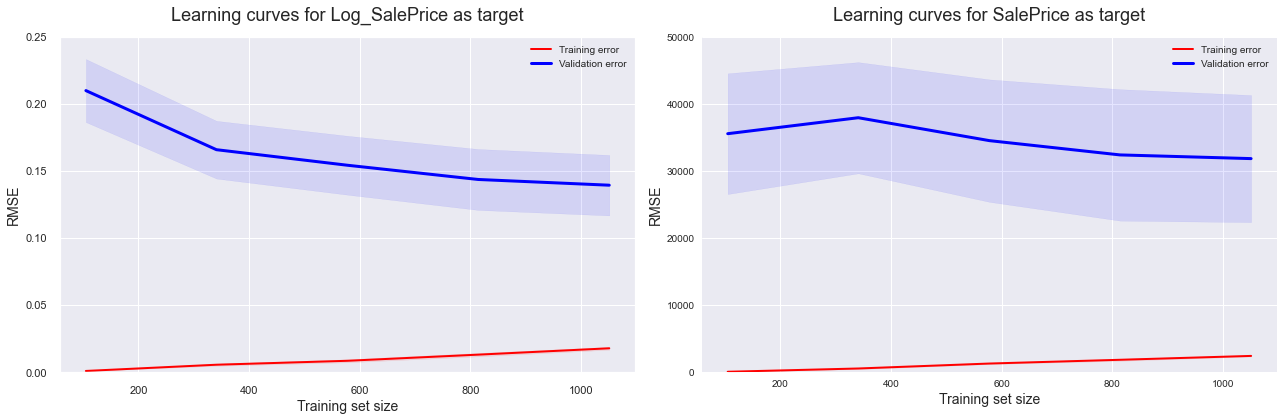

In [489]:
# Plotting the two learning curves #
plt.figure(figsize = (18,6))
estimator =[xgbr_log,xgbr]
titles = ['Log_SalePrice','SalePrice']

for model, X,y, title,i,ylim in [(xgbr_log, X_train_log, y_train_log, titles[0], 1, 0.25), 
                                 (xgbr, X_train, y_train, titles[1],2, 50000)]:
    plt.subplot(1,2,i)
    plot_learning_curves(model, X, y, title, ylim)

* **We cannot compare the RMSE on both plot as a ratio since left plot is achieved using its log value and on right plot using actual value, but we can compare the actual RMSE prediction**
* **In both plot, errors has huge gap but even tho training and validation error is converging.  It is an overfitting model. Two ways to improve current model:**

 * **Add more training set. The two curves would continue to get closer for the validation curve doesn't plateau at the maximum training set size.** 

 * **Reduce the numbers of features in the training data. This should decrease the variance and increase the bias.**

In [490]:
cv_score_log = cross_val_score(xgbr_log, X_train_log, y_train_log, cv= 10)
cv_score = cross_val_score(xgbr, X_train, y_train, cv= 10)

print(cv_score_log.mean())
print(cv_score.mean())

0.869629512145176
0.8146020919094834


### Testing

In [491]:
# X_test_log and X_test has definitely same data, I just makke their name differ
y_pred_log = xgbr_log.predict(X_test_log)
y_pred = xgbr.predict(X_test)

In [492]:
mse_test_log = mean_squared_error(np.exp(y_test_log), np.exp(y_pred_log))
rmse_test_log = np.sqrt(mse_test_log)
r2_test_log = r2_score(np.exp(y_test_log), np.exp(y_pred_log))

mse_test = mean_squared_error(y_test, y_pred)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test, y_pred)

model_versus = pd.DataFrame({'model':['xgbr_log','xgbr'],
                            'R_squared':['%.3f'% r2_test_log,'%.3f'% r2_test],
                            'RMSE_predict':['%.3f'% rmse_test_log,'%.3f'% rmse_test],
                            'cv_score_mean':['%.3f'% cv_score_log.mean(),'%.3f'% cv_score.mean()],
                           })
model_versus.style.hide_index()

model,R_squared,RMSE_predict,cv_score_mean
xgbr_log,0.917,22654.086,0.870
xgbr,0.878,27452.581,0.815


* **The xgbr_log model is better than the xgbr**

### Residual check

<function matplotlib.pyplot.show(close=None, block=None)>

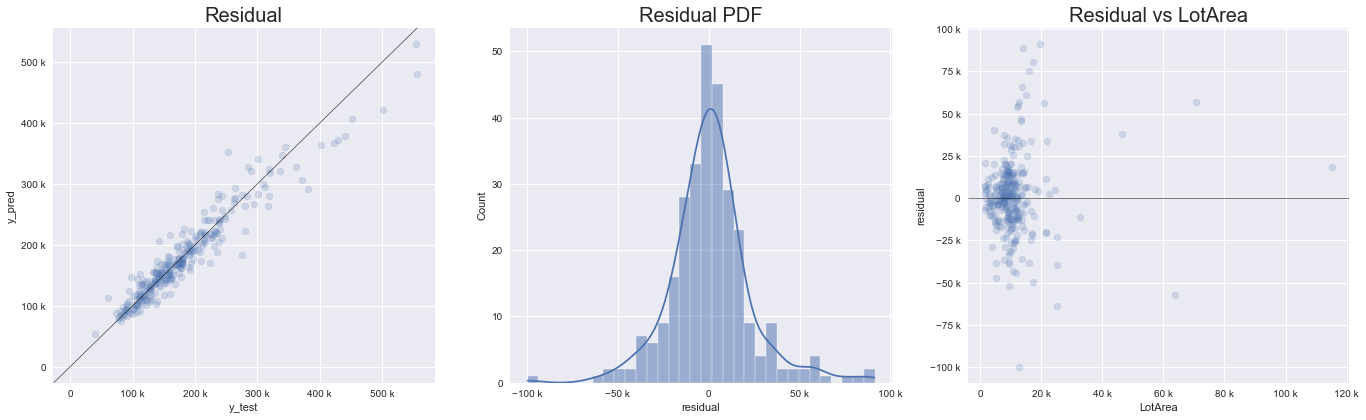

In [493]:
residual_test_log = np.exp(y_test_log) - np.exp(y_pred_log)
fig, ax = plt.subplots(1, 3, figsize= (19,6))

parameters = {'xtick.labelsize': 15,
              'ytick.labelsize': 15,
              'axes.labelsize': 15,
              'axes.titlesize': 20,}

plt.rcParams.update(parameters)

ax[0].scatter(np.exp(y_test_log), np.exp(y_pred_log), alpha= 0.2)
ax[0].set_title('Residual')
ax[0].set_xlabel('y_test')
ax[0].set_ylabel('y_pred')
ax[0].axline([0, 0], [1, 1], color='k', lw=0.5)

sns.histplot((residual_test_log), kde= True, ax = ax[1])
ax[1].set_title('Residual PDF')
ax[1].set_xlabel('residual')

ax[2].scatter(x= X_test['LotArea'],y = residual_test_log,alpha=0.2)
ax[2].axhline(y=0, color= 'black', lw=0.5)
ax[2].set_title('Residual vs LotArea')
ax[2].set_xlabel('LotArea')
ax[2].set_ylabel('residual')

for i in range(0,3):

    ax[i].xaxis.set_major_formatter(ticker.EngFormatter())
    ax[i].yaxis.set_major_formatter(ticker.EngFormatter())

plt.show

***

### Data Performance

In [494]:
# Since we predict the logarthmic value, we need to find the exponential value to get the actual value

df_pf = pd.DataFrame(np.exp(y_test_log.reset_index(drop=True)))
df_pf.rename(columns = {'log_saleprice':'Target_(SalePrice)'},inplace= True)
df_pf['Prediction'] = pd.DataFrame(np.exp(y_pred_log))
df_pf['Residual'] = df_pf['Target_(SalePrice)'] - df_pf['Prediction']
df_pf['Difference%'] = df_pf['Residual']/df_pf['Target_(SalePrice)']*100

df_pf.head(5)

,Target_(SalePrice),Prediction,Residual,Difference%
0,107000.00,143627.17,-36627.17,-34.23
1,101000.00,95255.24,5744.76,5.69
2,244000.00,279826.31,-35826.31,-14.68
3,155000.00,168160.77,-13160.77,-8.49
4,318061.00,280560.38,37500.62,11.79


In [495]:
# Ignore the Mean since it will sum up the negative and positive
df_pf.describe()

,Target_(SalePrice),Prediction,Residual,Difference%
count,292.00,292.00,292.00,292.00
mean,179330.63,178168.70,1161.96,-0.96
std,78849.71,72426.88,22663.11,12.75
min,39300.00,54139.05,-99675.37,-86.70
25%,127000.00,130146.23,-10796.95,-5.98
50%,160975.00,165011.24,959.11,0.56
75%,213250.00,210949.93,9594.46,6.02
max,556581.00,530305.00,91257.38,33.19


In [496]:
mean_dif = sum(np.absolute(df_pf['Difference%']))/len(df_pf['Difference%'])
print('Mean Difference%: ' + str('%.2f'% mean_dif)+'%')


Mean Difference%: 8.84%


In [497]:
pd.options.display.max_rows = 999
pd.set_option('display.float_format', lambda x: '%.2f' % x)
df_pf.sort_values(by = ['Difference%'])

,Target_(SalePrice),Prediction,Residual,Difference%
266,60000.00,112017.08,-52017.08,-86.70
86,97500.00,147206.77,-49706.77,-50.98
5,143000.00,206642.53,-63642.53,-44.51
275,253293.00,352968.38,-99675.37,-39.35
30,39300.00,54139.05,-14839.05,-37.76
267,160000.00,217026.55,-57026.55,-35.64
161,112000.00,151722.39,-39722.39,-35.47
0,107000.00,143627.17,-36627.17,-34.23
46,94750.00,124009.34,-29259.34,-30.88
125,139000.00,172797.80,-33797.80,-24.31


***
### Test.csv
***

In [498]:
test = pd.read_csv('test.csv')
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.00,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.00,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.00,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.00,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.00,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [499]:
df_test = test
df_test.describe(include='all')

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
count,1459.00,1459.00,1455,1232.00,1459.00,1459,107,1459,1459,1457,...,1459.00,1459.00,3,290,51,1459.00,1459.00,1459.00,1458,1459
unique,NaN,NaN,5,NaN,NaN,2,2,4,4,1,...,NaN,NaN,2,4,3,NaN,NaN,NaN,9,6
top,NaN,NaN,RL,NaN,NaN,Pave,Grvl,Reg,Lvl,AllPub,...,NaN,NaN,Ex,MnPrv,Shed,NaN,NaN,NaN,WD,Normal
freq,NaN,NaN,1114,NaN,NaN,1453,70,934,1311,1457,...,NaN,NaN,2,172,46,NaN,NaN,NaN,1258,1204
mean,2190.00,57.38,NaN,68.58,9819.16,NaN,NaN,NaN,NaN,NaN,...,17.06,1.74,NaN,NaN,NaN,58.17,6.10,2007.77,NaN,NaN
std,421.32,42.75,NaN,22.38,4955.52,NaN,NaN,NaN,NaN,NaN,...,56.61,30.49,NaN,NaN,NaN,630.81,2.72,1.30,NaN,NaN
min,1461.00,20.00,NaN,21.00,1470.00,NaN,NaN,NaN,NaN,NaN,...,0.00,0.00,NaN,NaN,NaN,0.00,1.00,2006.00,NaN,NaN
25%,1825.50,20.00,NaN,58.00,7391.00,NaN,NaN,NaN,NaN,NaN,...,0.00,0.00,NaN,NaN,NaN,0.00,4.00,2007.00,NaN,NaN
50%,2190.00,50.00,NaN,67.00,9399.00,NaN,NaN,NaN,NaN,NaN,...,0.00,0.00,NaN,NaN,NaN,0.00,6.00,2008.00,NaN,NaN
75%,2554.50,70.00,NaN,80.00,11517.50,NaN,NaN,NaN,NaN,NaN,...,0.00,0.00,NaN,NaN,NaN,0.00,8.00,2009.00,NaN,NaN


In [500]:
# Separating the numerical and categorical data
unique_value_test = pd.DataFrame(df_test.describe(include='all').loc['mean',:])
df_test_categorical= unique_value_test.loc[unique_value['mean'].isnull()].index
df_test_numerical= unique_value_test.loc[unique_value['mean'].notnull()].index

df_test_categorical= pd.DataFrame(df_test_categorical,columns=['Categorical'])
df_test_numerical= pd.DataFrame(df_test_numerical,columns=['Numerical'])

df_test_type= df_test_categorical.join(df_test_numerical)
df_test_type.head()

,Categorical,Numerical
0,MSZoning,Id
1,Street,MSSubClass
2,Alley,LotFrontage
3,LotShape,LotArea
4,LandContour,OverallQual


In [501]:
test_sum_null= pd.DataFrame(df_test.isnull().sum())
test_sum_null.columns =['null_value']

test_sum_null= test_sum_null[test_sum_null['null_value']>0]
test_sum_null = test_sum_null.reset_index()
test_sum_null.columns = ['Feature','null_value']

test_sum_null.head()

,Feature,null_value
0,MSZoning,4
1,LotFrontage,227
2,Alley,1352
3,Utilities,2
4,Exterior1st,1


In [502]:
test_null_list = []

for i in test_sum_null['Feature'].values :
    if i in df_test_type['Categorical'].values :
        test_null_list.append('Cat')
    if i in df_test_type['Numerical'].values :
        test_null_list.append('Num')
        
test_null_list = pd.DataFrame(test_null_list)
test_null_list.columns = ['Type']
test_sum_null= test_sum_null.join(test_null_list)

test_sum_null.head()

,Feature,null_value,Type
0,MSZoning,4,Cat
1,LotFrontage,227,Num
2,Alley,1352,Cat
3,Utilities,2,Cat
4,Exterior1st,1,Cat


In [503]:
test_sum_null_num= test_sum_null[test_sum_null['Type'] == 'Num']
test_sum_null_cat= test_sum_null[test_sum_null['Type'] == 'Cat']
test_sum_null_num
# this time we get more missing value than in train.csv
# even so, we still only fill the missing value like in train.csv feature before 

,Feature,null_value,Type
1,LotFrontage,227,Num
7,MasVnrArea,15,Num
12,BsmtFinSF1,1,Num
14,BsmtFinSF2,1,Num
15,BsmtUnfSF,1,Num
16,TotalBsmtSF,1,Num
17,BsmtFullBath,2,Num
18,BsmtHalfBath,2,Num
23,GarageYrBlt,78,Num
25,GarageCars,1,Num


In [504]:
# Dealing with missing value
df_test['LotFrontage'] = df_test['LotFrontage'].replace(np.nan, np.mean(df_test['LotFrontage']))
df_test['MasVnrArea'] = df_test['MasVnrArea'].replace(np.nan, 0)
df_test['Alley'] = df_test['Alley'].replace(np.nan, 'NA')
df_test['MasVnrType'] = df_test['MasVnrType'].replace(np.nan, 'None')
df_test['BsmtQual'] = np.where(df_test['Id'] == 2218, 'TA', df_test['BsmtQual'])
df_test['BsmtQual'] = np.where(df_test['Id'] == 2219, 'TA', df_test['BsmtQual'])
df_test['BsmtQual'] = df_test['BsmtQual'].replace(np.nan, 'NA')
df_test['BsmtCond'] = np.where(df_test['Id'] == 2041, 'TA', df_test['BsmtCond'])
df_test['BsmtCond'] = np.where(df_test['Id'] == 2186, 'TA', df_test['BsmtCond'])
df_test['BsmtCond'] = np.where(df_test['Id'] == 2525, 'TA', df_test['BsmtCond'])
df_test['BsmtCond'] = df_test['BsmtCond'].replace(np.nan, 'NA')
df_test['BsmtExposure'] = np.where(df_test['Id'] == 1488, 'No', df_test['BsmtExposure'])
df_test['BsmtExposure'] = np.where(df_test['Id'] == 2349, 'No', df_test['BsmtExposure'])
df_test['BsmtExposure'] = df_test['BsmtExposure'].replace(np.nan, 'NA')
df_test['BsmtFinType2'] = df_test['BsmtFinType2'].replace(np.nan, 'NA')
df_test['BsmtFinType1'] = df_test['BsmtFinType1'].replace(np.nan, 'NA')
df_test['FireplaceQu'] = df_test['FireplaceQu'].replace(np.nan, 'NA')
df_test['GarageType'] = df_test['GarageType'].replace(np.nan, 'NA')
df_test['GarageYrBlt'] = df_test['GarageYrBlt'].replace(np.nan, np.mean(df_test['GarageYrBlt']))
df_test['GarageFinish'] = np.where(df_test['Id'] == 2577, 'TA', df_test['GarageFinish'])
df_test['GarageFinish'] = np.where(df_test['Id'] == 2041, 'TA', df_test['GarageFinish'])
df_test['GarageFinish'] = df_test['GarageFinish'].replace(np.nan, 'NA')
df_test['GarageQual'] = df_test['GarageQual'].replace(np.nan, 'NA')
df_test['GarageCond'] = df_test['GarageCond'].replace(np.nan, 'NA')
df_test['PoolQC'] = df_test['PoolQC'].replace(np.nan, 'NA')
df_test['Fence'] = df_test['Fence'].replace(np.nan, 'NA')
df_test['MiscFeature'] = df_test['MiscFeature'].replace(np.nan, 'NA')


In [505]:
df_test_num = df_test[list(df_test_type['Numerical'][1:37])]
df_test_num.columns

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')

In [506]:
cat_test_ohe = ohe.fit_transform(df_test[list(df_test_type['Categorical'])])

In [507]:
categorical_test_cols = df_test_type['Categorical']

In [508]:
df_test_cat_ohe = pd.DataFrame(cat_test_ohe,columns= ohe.get_feature_names(input_features = categorical_test_cols))
df_test_cat_ohe

,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,MSZoning_nan,Street_Grvl,Street_Pave,Alley_Grvl,Alley_NA,...,SaleType_New,SaleType_Oth,SaleType_WD,SaleType_nan,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,...,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
1,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,1.00,...,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
2,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,1.00,...,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
3,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,1.00,...,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
4,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,1.00,...,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,1.00,...,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
1455,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,1.00,...,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00
1456,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,1.00,...,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00
1457,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,1.00,...,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00


In [509]:
df_test_preprocessed = df_test_num.join(df_test_cat_ohe)

In [510]:
# We will call data from test.csv as 'new'
X_new = df_test_preprocessed

In [511]:
# Get missing columns in the training test
missing_cols = set(X_train.columns) - set(X_new.columns)
# Add a missing column in test.csv set with default value equal to 0
for i in missing_cols:
    X_new[i] = 0
# Ensure the order of column in the test set is in the same order than in train.csv
X_new = X_new[X_train.columns]

In [512]:
y_new_pred = xgbr_log.predict(X_new)

### Prediction

In [513]:
# Prediction for test.csv
df_test_pf = pd.DataFrame(np.exp(y_new_pred), columns =['Test_Prediction'])
df_test_pf.insert(0,'Id',df_test['Id'].values)
df_test_pf.columns = ['Id', 'SalePrice']

df_test_pf.head(5)

,Id,SalePrice
0,1461,130542.51
1,1462,166960.05
2,1463,194669.03
3,1464,197399.62
4,1465,188931.78


In [514]:
df_test_pf.to_csv('submission.csv',index=False)